In [1]:
%load_ext autoreload
%autoreload 2

from hossam.util import *
from hossam.plot import *
from hossam.tensor import *
from pandas import read_excel, pivot_table, melt, to_datetime, to_timedelta, concat, merge, DataFrame, DateOffset
from collections import defaultdict
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta

import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
origin = read_excel('데이터 파일\총매출현황.xlsx')
origin

,일 자,일 계,매 출,Unnamed: 3,Unnamed: 4,Unnamed: 5,환 불,Unnamed: 7,Unnamed: 8
0,NaN,NaN,소 계,현 금,카 드,미수금,소 계,현 금,카 드
1,2020-02-29,4.400000e+05,440000,0,440000,0,0,0,0
2,2020-03-01,2.310000e+06,2310000,880000,1430000,0,0,0,0
3,2020-03-02,-2.205000e+06,4585000,0,4585000,0,-6790000,0,-6790000
4,2020-03-03,5.240000e+06,5240000,50000,5190000,0,0,0,0
...,...,...,...,...,...,...,...,...,...
1262,2024-02-26,2.495600e+07,24956000,600000,24356000,1200000,0,0,0
1263,2024-02-27,9.502000e+06,9628000,1305000,8323000,5755000,-126000,0,-126000
1264,2024-02-28,1.078680e+07,10786800,0,10786800,1521000,0,0,0
1265,2024-02-29,1.275870e+07,12758700,688000,12070700,3984000,0,0,0


In [10]:
columns_to_drop = ['일    계','Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 7', 'Unnamed: 8']
origin = origin.drop(columns_to_drop, axis=1)
origin

,일 자,매 출,환 불
0,NaN,소 계,소 계
1,2020-02-29,440000,0
2,2020-03-01,2310000,0
3,2020-03-02,4585000,-6790000
4,2020-03-03,5240000,0
...,...,...,...
1262,2024-02-26,24956000,0
1263,2024-02-27,9628000,-126000
1264,2024-02-28,10786800,0
1265,2024-02-29,12758700,0


In [11]:
origin = origin.drop(origin.index[0])
origin

,일 자,매 출,환 불
1,2020-02-29,440000,0
2,2020-03-01,2310000,0
3,2020-03-02,4585000,-6790000
4,2020-03-03,5240000,0
5,2020-03-04,4400000,0
...,...,...,...
1262,2024-02-26,24956000,0
1263,2024-02-27,9628000,-126000
1264,2024-02-28,10786800,0
1265,2024-02-29,12758700,0


In [13]:
origin = origin.drop(origin.index[1265])
origin

,일 자,매 출,환 불
1,2020-02-29,440000,0
2,2020-03-01,2310000,0
3,2020-03-02,4585000,-6790000
4,2020-03-03,5240000,0
5,2020-03-04,4400000,0
...,...,...,...
1261,2024-02-24,1650000,0
1262,2024-02-26,24956000,0
1263,2024-02-27,9628000,-126000
1264,2024-02-28,10786800,0


In [20]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1265 entries, 1 to 1265
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   일    자  1265 non-null   object
 1   매    출  1265 non-null   object
 2   환    불  1265 non-null   object
dtypes: object(3)
memory usage: 29.8+ KB


In [21]:
df = origin.copy()
# '일자' 열을 날짜 형식으로 변환합니다.
df['일    자'] = pd.to_datetime(origin['일    자'])

# '일자' 열에서 연월만 추출하여 새로운 '연월' 열을 만듭니다.
df['연월'] = df['일    자'].dt.to_period('M')

# '일자' 열을 제거합니다.
df = df.drop('일    자', axis=1)
df

,매 출,환 불,연월
1,440000,0,2020-02
2,2310000,0,2020-03
3,4585000,-6790000,2020-03
4,5240000,0,2020-03
5,4400000,0,2020-03
...,...,...,...
1261,1650000,0,2024-02
1262,24956000,0,2024-02
1263,9628000,-126000,2024-02
1264,10786800,0,2024-02


In [22]:
month_total = df.groupby('연월').sum()
month_total

,매 출,환 불
연월,,
2020-02,440000,0
2020-03,115507000,-12289000
2020-04,181454184,-7560000
2020-05,179921134,-14060000
2020-06,268538964,-20069000
2020-07,224768053,-13905000
2020-08,150912530,-10082000
2020-09,133704031,-20096500
2020-10,195036000,-16194010


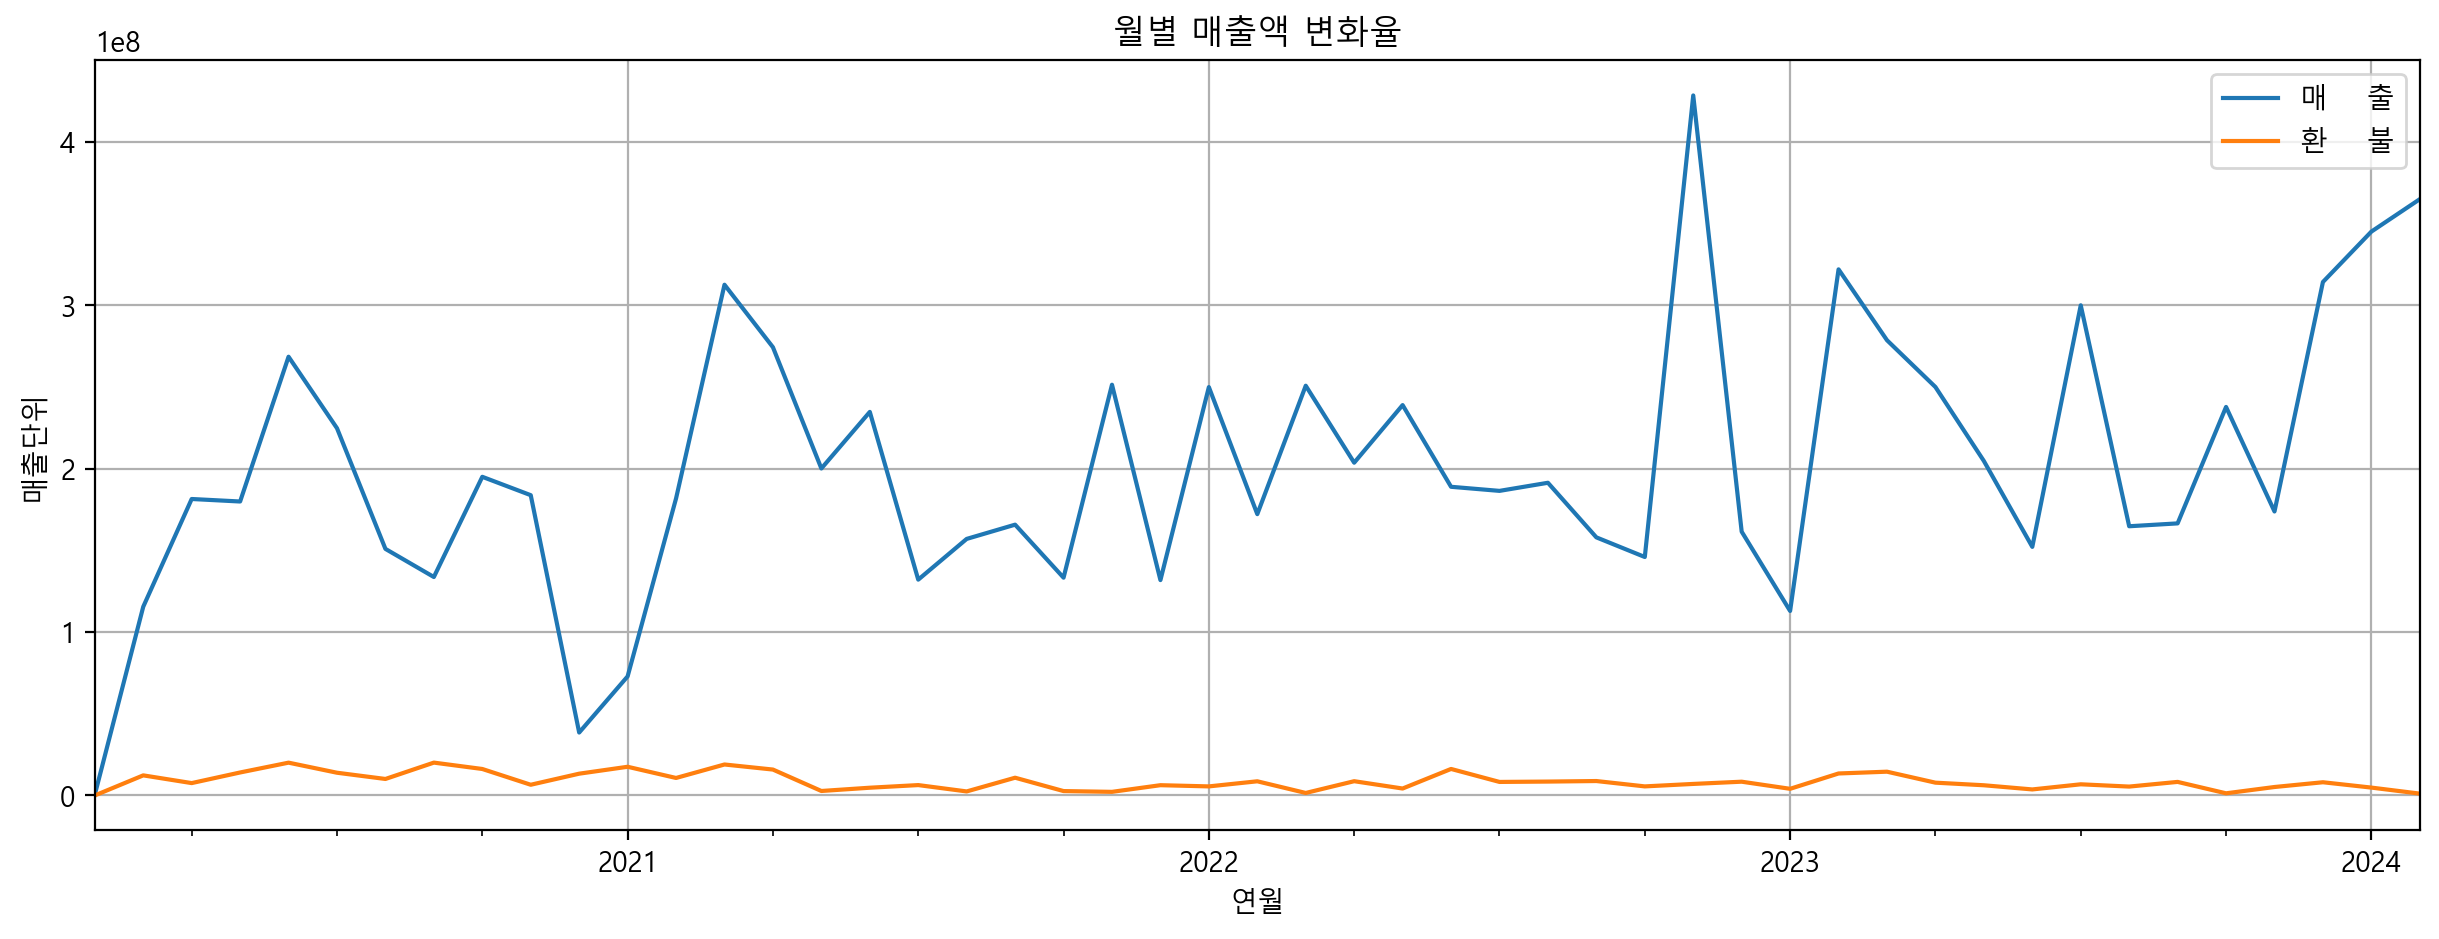

: 

In [26]:
target = month_total[['매    출','환    불']]
target['환    불'] = target['환    불'].abs()
target.plot(figsize=(15,5))
plt.grid()
plt.legend()
plt.title("월별 매출액 변화율")
plt.ylabel("매출단위")
plt.show()
plt.close()